In [1]:
from string import punctuation

import numpy as np
from PIL import Image

In [2]:
PATH_TO_DATA = '../data/'

TEXT_FILES_DIR = PATH_TO_DATA + 'Flickr8k_text/'
IMAGES_DIR = PATH_TO_DATA + 'Flickr8k_Dataset/'

***

## Understanding and formating the data

In [3]:
with open(TEXT_FILES_DIR + 'Flickr8k.token.txt', 'r') as flickr8_token:
    raw_image_description = flickr8_token.read().split('\n')[:-1]

print('\n'.join(raw_image_description[:10]))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


In [4]:
def get_dict_image_descriptions(raw_image_description):
    image_descriptions = dict()
    
    i = 0
    while i < len(raw_image_description):
        img_name = raw_image_description[i].split('.')[0]
        image_descriptions[img_name] = []
        
        while i < len(raw_image_description) and img_name == raw_image_description[i].split('.')[0]:
            descr = raw_image_description[i].split('\t')[1]
            image_descriptions[img_name].append(descr)
            i+=1
            
    return image_descriptions

image_descriptions = get_dict_image_descriptions(raw_image_description)

In [5]:
image_descriptions['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

***

## Data Cleaning

In [6]:
def clean(sentence):
    # Tokenize
    tokens = sentence.split()
    
    # Lower Case
    tokens = [token.lower() for token in tokens]
    
    # Remove punct
    for i in range(len(tokens)):
        tokens[i] = ''.join([ch for ch in tokens[i] if ch not in punctuation])
    
    # Remove hanging chars
    tokens = [token for token in tokens if (len(token) > 1 or token == 'a')]
    
    # Remove tokens with digits in it
    tokens = [token for token in tokens if token.isalpha()]
    
    return ' '.join(tokens)

In [7]:
clean(
    'A HellO! How12 are yoU>??'
)

'a hello are you'

In [8]:
for img_name, descriptions in image_descriptions.items():
    image_descriptions[img_name] = [clean(descr) for descr in descriptions]

In [9]:
image_descriptions['101654506_8eb26cfb60']

['a brown and white dog is running through the snow',
 'a dog is running in the snow',
 'a dog running through snow',
 'a white and brown dog is running through a snow covered field',
 'the white and brown dog is running over the surface of the snow']

***

## Create a Vocabulary

In [10]:
vocabulary = set()

for key in image_descriptions.keys():
    [vocabulary.update(descr.split()) for descr in image_descriptions[key]]
    
print(f'Original Vocabulary size: {len(vocabulary)}')

Original Vocabulary size: 8764


### Add zero for zero-padding

In [11]:
vocabulary.update('0')

### Sort the Vocabulary lexically

In [12]:
vocabulary = sorted(vocabulary)

## Word2Idx and Idx2Word maps

In [13]:
word2idx = dict([(list(vocabulary)[i], i) for i in range(len(vocabulary))])
idx2word = dict([(i, list(vocabulary)[i]) for i in range(len(vocabulary))])

In [14]:
word2idx['dog']

2222

In [15]:
idx2word[2222]

'dog'

***

## Max Description Length

In [16]:
descriptions = []

for key, val in image_descriptions.items():
    for descr in val:
        descriptions.append(descr)

print(f'Total number of descriptions: {len(descriptions)}')

Total number of descriptions: 40460


In [17]:
longets_description = max(descriptions, key=lambda x: len(x.split()))

print(f'Longes description:\n\n"{longets_description}"')

Longes description:

"an africanamerican man wearing a green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on a busy sidewalk in front of a group of men playing instruments"


In [18]:
max_description_length = len(longets_description.split())

print(f'Max Description Length: {max_description_length}')

Max Description Length: 35


***

## Train/Dev/Test split

In [19]:
def load_set_images(filename):
    with open(filename, 'r') as f:
        img_names = f.read().split('\n')[:-1]
        
    img_names = [name.split('.')[0] for name in img_names]
    return img_names

In [20]:
train_images = load_set_images(TEXT_FILES_DIR + 'Flickr_8k.trainImages.txt')
dev_images = load_set_images(TEXT_FILES_DIR + 'Flickr_8k.devImages.txt')
test_images = load_set_images(TEXT_FILES_DIR + 'Flickr_8k.testImages.txt')

print(f'Train size: {len(train_images)}')
print(f'Dev size: {len(dev_images)}')
print(f'Test size: {len(test_images)}')

Train size: 6000
Dev size: 1000
Test size: 1000


In [21]:
def init_image_descriptions_set(set_images):
    image_descriptions_set = dict()
    
    for img_name in set_images:
        image_descriptions_set[img_name] = []
        descriptions = image_descriptions[img_name]
        
        for descr in descriptions:
            image_descriptions_set[img_name].append(
                '<SOS> ' + descr + ' <EOS>'
            )
    
    return image_descriptions_set

In [22]:
train_image_descriptions = init_image_descriptions_set(train_images)
dev_image_descriptions = init_image_descriptions_set(dev_images)
test_image_descriptions = init_image_descriptions_set(test_images)

print(f'Train size: {len(train_image_descriptions)}')
print(f'Dev size: {len(dev_image_descriptions)}')
print(f'Test size: {len(test_image_descriptions)}')

Train size: 6000
Dev size: 1000
Test size: 1000


In [23]:
train_image_descriptions['2513260012_03d33305cf']

['<SOS> a black dog is running after a white dog in the snow <EOS>',
 '<SOS> black dog chasing brown dog through snow <EOS>',
 '<SOS> two dogs chase each other across the snowy ground <EOS>',
 '<SOS> two dogs play together in the snow <EOS>',
 '<SOS> two dogs running through a low lying body of water <EOS>']

`<SOS>` = **Start Of Sequence** <br>
`<EOS>` = **End Of Sequence** <br>

***

## Data Generator

In [24]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [25]:
def load_image(filename, target_size=(299, 299)) :
    img = Image.open(filename)
    img.load()
    img = img.resize(target_size)
    return np.asarray(img, dtype='int32')

Image shape: (299, 299, 3)


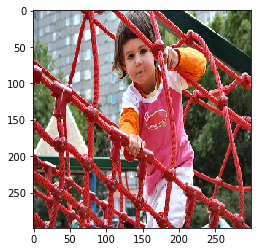

In [26]:
img = load_image(IMAGES_DIR+'1007320043_627395c3d8.jpg')
print(f'Image shape: {img.shape}')

plt.imshow(img);

In [27]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(image_descriptions_set, img_names_set, word2idx, max_length, num_images_per_batch):
    X_img = np.zeros((num_images_per_batch*5, 299, 299, 3))
    X_seq = []
    Y_seq = []
    n = 0
    
    # loop for ever over images
    while True:
        for img_name, desc_list in image_descriptions_set.items():
            n+=1

            # retrieve the photo feature
            img = load_image(IMAGES_DIR + img_name + '.jpg')

            for desc in desc_list:
                X_img[n] = img
                
                # encode the sequence
                y_seq = [word2idx[word] for word in desc.split() if word in word2idx]
                x_seq = [word2idx['0']] + y_seq[:-1]
                
                Y_seq.append(y_seq)
                X_seq.append(x_seq)

            # yield the batch data
            if n == num_images_per_batch:
                X_seq = pad_sequences(X_seq, maxlen=max_length, padding='post')
                Y_seq = pad_sequences(Y_seq, maxlen=max_length, padding='post')
                
                # One-hot
                Y_seq = [[to_categorical(idx, len(vocabulary)) for idx in sent] for sent in Y_seq]
                
                yield [[X_img, X_seq], np.array(Y_seq)]

                X_img = np.zeros((num_images_per_batch*5, 299, 299, 3))
                X_seq = []
                Y_seq = []
                n = 0

***

In [28]:
from keras import Model
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Input, Embedding, Dropout, LSTM, Dense, Activation, Reshape
from keras.optimizers import Adam
from keras.utils import plot_model



# Image Encoder (ConvNet)

We are making use of the **Transfer Learning** technique.<br>
We are using the CNN Inception V3 trained on ImageNet by Google Brain team on Cloud TPUs.
<br><br>

Here is the network architecture:
![InceptionV3](../img/InceptionV3.png)

In [29]:
IMG_VECTOR_DIM = 256

In [30]:
def init_image_encoder():
    img_in = Input((299, 299, 3))
    
    # Get the InceptionV3 model trained on imagenet data
    inceptionv3 = InceptionV3(weights='imagenet')
    # Remove the last layer (output softmax layer) from the inception v3
    inceptionv3 = Model(inceptionv3.input, inceptionv3.layers[-2].output)
    
    # Do not alter the weights of the InceptionV3 model
    for layer in inceptionv3.layers:
        layer.trainable = False
    
    x = inceptionv3(img_in)
    x = Dropout(0.5)(x)
    x = Dense(IMG_VECTOR_DIM)(x)
    x = Activation('relu')(x)
    
    return Model(img_in, x, name='image_encoder')

***

# Sequence Decoder (LSTM)
<br>
A LSTM network

![LSTM_net](../img/LSTM.png)

***

## Word Embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/))

In [31]:
GLOVE_300_DIR = PATH_TO_DATA + 'glove.6B/glove.6B.300d.txt'

def load_word_embedding_map(path_to_embeddings):
    word_embedding = dict()

    with open(GLOVE_300_DIR, encoding='utf-8') as f_embeddings:
        for line in f_embeddings:
            values = line.split()
            word_embedding[values[0]] = np.asarray(values[1:], dtype='float64')
    
    return word_embedding


# Load the Word Embeddings
word_embedding = load_word_embedding_map(GLOVE_300_DIR)

In [32]:
def cosine_similarity(v, w):
    return np.dot(v, w) / (np.linalg.norm(v) * np.linalg.norm(w))

In [33]:
cosine_similarity(
    word_embedding['man'] - word_embedding['woman'],
    word_embedding['king'] - word_embedding['queen']
)

0.40070248182725027

### Init the embedding matrix

In [34]:
def init_embedding_matrix(dim):
    embedding_matrix = np.zeros((len(vocabulary), dim))

    for word, idx in word2idx.items():
        try:
            embedding_matrix[idx, :] = word_embedding[word]
        except KeyError:
            pass
        
    return embedding_matrix

embedding_matrix = init_embedding_matrix(300)
print(f'Embedding Matrix shape: {embedding_matrix.shape}')

Embedding Matrix shape: (8765, 300)


***

# Model

![NIC_model](../img/NIC.png)

In [35]:
def init_model():
    img_in = Input((299, 299, 3), name='image_input')
    
    img_encoder = init_image_encoder()
    img_vector = img_encoder(img_in)
    encoder_states = [img_vector, img_vector]
    
    # Sequence Input
    seq_in = Input((max_description_length,), name='sequence_input')
    
    # GloVe embeddings
    glove_embeddings = Embedding(
        len(vocabulary),
        300,
        input_length=max_description_length,
        mask_zero=True,
        name='glove_embeddings'
    )
    x = glove_embeddings(seq_in)
    
    # Dropout
    x = Dropout(0.5, name='dropout')(x)
    
    # Sequence Decoder
    sequence_decoder = LSTM(IMG_VECTOR_DIM, return_sequences=True, name='sequence_decoder')
    x = sequence_decoder(x, initial_state=encoder_states)
    
    # Dense -> Softmax
    x = Dense(len(vocabulary), name='dense_decoder')(x)
    x = Activation('softmax', name='softmax_decoder')(x)
    
    # Build the model
    model = Model(inputs=[img_in, seq_in], outputs=x)
    # Set GloVe weights
    model.get_layer('glove_embeddings').set_weights([embedding_matrix])
    model.get_layer('glove_embeddings').trainable = False
    
    return model

In [36]:
model = init_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Visualize the model

In [37]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 35)           0                                            
__________________________________________________________________________________________________
glove_embeddings (Embedding)    (None, 35, 300)      2629500     sequence_input[0][0]             
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 35, 300)      0           glove_embeddings[0][0]           
__________________________________________________________________________________________________
image_enco

## Training

In [38]:
model.compile(Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.fit_generator(
    data_generator(train_image_descriptions, train_images, word2idx, max_description_length, 5),
    steps_per_epoch=10,
    epochs=100,
    verbose=True,
    callbacks=[ReduceLROnPlateau()]
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
10/10 [==============================] - 27s 3s/step - loss: 9.0679 - acc: 0.0016
Epoch 2/100
10/10 [==============================] - 23s 2s/step - loss: 9.0263 - acc: 0.0689
Epoch 3/100
10/10 [==============================] - 23s 2s/step - loss: 8.9509 - acc: 0.1022
Epoch 4/100
10/10 [==============================] - 23s 2s/step - loss: 8.7854 - acc: 0.0946
Epoch 5/100
10/10 [==============================] - 23s 2s/step - loss: 8.4470 - acc: 0.0862
Epoch 6/100
10/10 [==============================] - 23s 2s/step - loss: 8.0140 - acc: 0.0866
Epoch 7/100
10/10 [==============================] - 23s 2s/step - loss: 7.4572 - acc: 0.0999
Epoch 8/100
10/10 [==============================] - 23s 2s/step - loss: 6.9627 - acc: 0.0958
Epoch 9/100
10/10 [==============================] - 23s 2s/step - loss: 6.5506 - acc: 0.1076
Epoch 10/100
10/10 [========

KeyboardInterrupt: 